In [1]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)

def lorentz(x, x_0, gamma, a, d):
    return a * 1/(1 + ((x - x_0)/gamma)**2) + d
def lorentzfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, x_0, gamma, a, d: a * 1/(1 + ((x - x_0)/gamma)**2) + d,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def linfitter(x,y):
    itera = 0
    start = 0
    stop = 0
    lastval = 0
    trigger = False
    for item in y:
        if (lastval-item) > 1:  # rampe primed
            trigger = True
        if trigger and item > -1 and start == 0: # startwert für sauberen fit
            start = itera
        if trigger and item > 1:  #  endwert sauberer fit
            stop = itera
            break
        itera += 1
        lastval = item
    return linfit_pm(x[start:stop],y[start:stop])

def lorenzer(x,y):
    if abs(y[0]+max(y))>abs(y[0]-min(y)):  # 0°-> peak über start
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1,-1,1))
    if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1,1,1))

def FWHM(x,params): 
    from sympy.solvers import solve
    from sympy import Symbol
    var = Symbol("var")
    x_0, gamma, a, d  = val(params)
    maximum = a+d
    left,right = solve(lorentz(var,*val(params))-(maximum/2),var)
    return abs(right-left)
FWHM(time_90,lor_params)

[22.65670776831208+/-0.00948387206659165
 0.9205123854939813+/-0.014236117105439797
 -4.629008351092628+/-0.0476973982032427
 0.8350313569340211+/-0.0064508998020781074]
[0.08670535037029395+/-0.0001646883661253939
 -1.871058351635329+/-0.0036774325422881094]


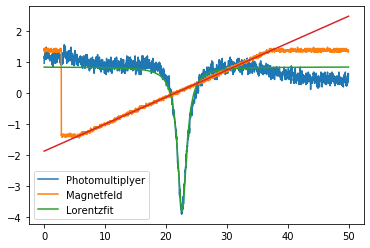

In [3]:
pos_90 = pd.read_csv("87.5_1_HM1508.csv")

time_90 = pos_90.iloc[0:,0].to_numpy()
ch1_90 = pos_90.iloc[0:,1].to_numpy()
ch2_90 = pos_90.iloc[0:,2].to_numpy()
lor_params,lor_r_2 = lorenzer(time_90,ch1_90) # lorentzfit
lin_params,lin_r_2 = linfitter(time_90,ch2_90) # linfit
print(lor_params)
print(lin_params)
#bad plot
plt.plot(time_90,ch1_90,label="Photomultiplyer")
plt.plot(time_90,ch2_90,label="Magnetfeld")
plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")
plt.plot(time_90,line(time_90,*val(lin_params)))
plt.legend()
plt.show()

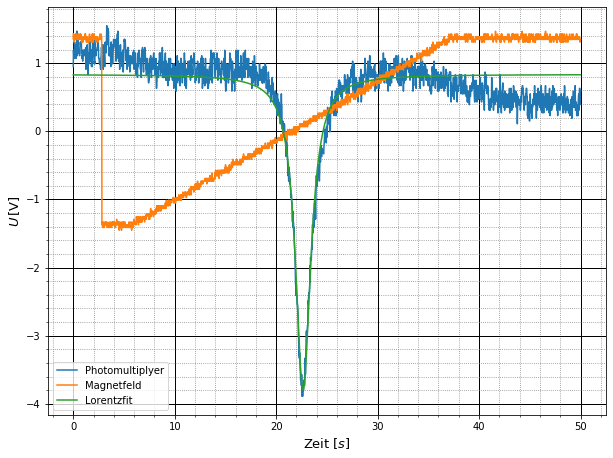

In [4]:
#nice plot
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(time_90,ch1_90,label="Photomultiplyer")
plt.plot(time_90,ch2_90,label="Magnetfeld")
plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")



###   Label / Title

plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
#plt.title('Titel', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('peak_first_single.png')
plt.show()

line params 0.08671+/-0.00016 -1.871+/-0.004 

[3.141022418846026e-05+/-2.765395548920709e-07
 2.684122948192432e-05+/-4.1510986134547524e-07
 -4.629008332404807+/-0.04769746743932436
 0.8350313582247493+/-0.006450897569210157]


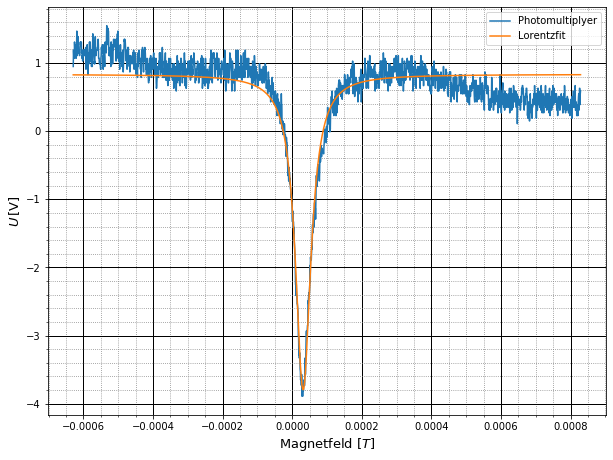

In [5]:
df = pd.read_csv("87.5_1_HM1508.csv")  # einlesen
time = df.iloc[0:,0].to_numpy()  # zeit
ch1 = df.iloc[0:,1].to_numpy()  # signal
ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
k = 3.363e-4
(a,b) = lin_params
print("line params",a,b,"\n")
B = (a*time+b)*k
x,y = val(B),ch1
lor_params,lor_r_2 = lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-4,min(y)-y[0],y[0]))
print(lor_params)


###   Errors / Fit / Plot

plt.plot(val(B),ch1,label="Photomultiplyer")
#plt.plot(val(B),ch2_90,label="Magnetfeld")
plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



###   Label / Title

plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
#plt.title('Titel', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
    #plt.savefig('peak_first_single.png')
plt.show()

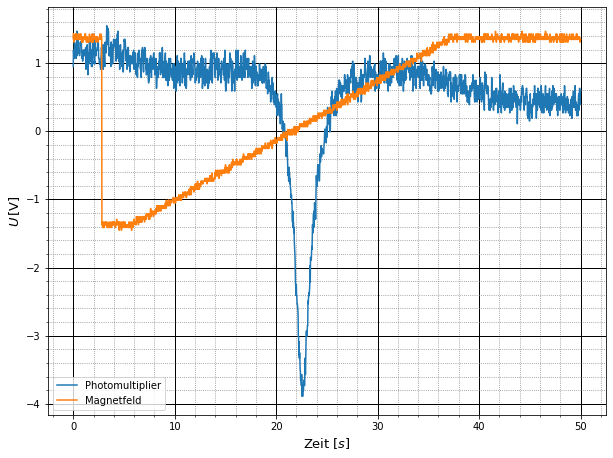

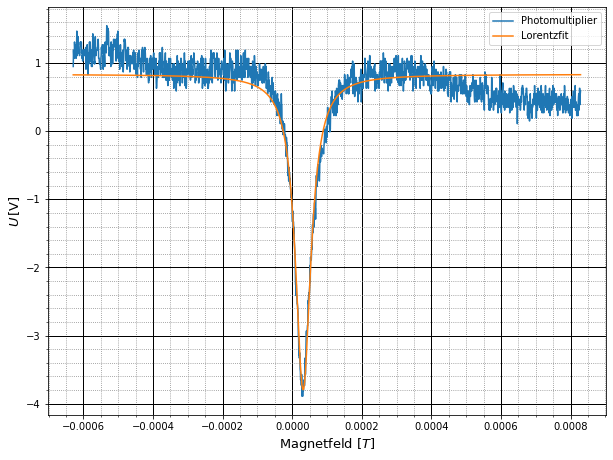

(1.428+/-0.022)e-07


In [6]:
def analysis(filename,plots=False,save=False,values=False ,**kwargs):
    def linfitter(x,y):
        itera = 0
        start = 0
        stop = 0
        lastval = 0
        trigger = False
        for item in y:
            if (lastval-item) > 1:  # rampe primed
                trigger = True
            if trigger and item > -1 and start == 0: # startwert für sauberen fit
                start = itera
            if trigger and item > 1:  #  endwert sauberer fit
                stop = itera
                break
            itera += 1
            lastval = item
        return linfit_pm(x[start:stop],y[start:stop])


    def lorenzer(x,y):
        if abs(y[0]+max(y))>abs(y[0]-min(y)):  # 0°-> peak über start
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-4,max(y)-y[0],y[0]))
        if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-4,min(y)-y[0],y[0]))


    # konstanten
    k = 3.363e-4
    gJ = 1.4838
    muB = 9.274009e-24
    hb = 1.0546e-34
    
    # daten einlesen, in arrays umwandeln
    df = pd.read_csv(filename)  # einlesen
    time = df.iloc[0:,0].to_numpy()  # zeit
    ch1 = df.iloc[0:,1].to_numpy()  # signal
    ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(time_90,ch1_90,label="Photomultiplier")
        plt.plot(time_90,ch2_90,label="Magnetfeld")
        #plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
        #plt.title('Titel', fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            
            plt.savefig(filename[-4]+"_raw"+".png")
        plt.show()
        
    # B(t) bestimmen
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
    (a,b) = lin_params
    if values:
        print("line params",a,b,"\n")
    B = (a*time+b)*k
    if values:
        print("B",B,"\n")
    # fit B(t) signal
    lor_params,lor_r_2 = lorenzer(val(B),ch1)
    if values:
        print("lor params",lor_params,"\n")
    x_0, gamma, a, d = lor_params
    
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(val(B),ch1,label="Photomultiplier")
        #plt.plot(val(B),ch2_90,label="Magnetfeld")
        plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
        #plt.title('Titel', fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            plt.savefig(filename[:-4]+"_lorenz"+'.png')
        plt.show()
    
    
    FWHM = 2*gamma
    if values:
        print(FWHM)
    # tau berechnen
    tau = hb/(gJ*muB*FWHM)
    
    return tau

print(analysis("87.5_1_HM1508.csv",True))